In [129]:
import numpy as np
import scipy.special
import scipy.integrate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import emcee
from scipy.optimize import root_scalar
import agama
import corner
import astropy.coordinates as coord
import astropy.units as u
import multiprocessing

In [130]:
agama.setUnits(length=1, mass=1e10, velocity=1)
# 常数和参数（单位：kpc, Gyr, 10^10 Msun）
G = 43018  # 单位转换后：kpc³/(10¹⁰ Msun·Gyr²)
M_bulge = 1.0    # 10¹⁰ Msun (原1e10 Msun)
M_disk = 6.8    # 10¹⁰ Msun (原5e10 Msun)
a_disk = 3.     # kpc
b_disk =0.28
a_bulge = 0.5 
disk = agama.Potential(type='MiyamotoNagai', mass=M_disk, scaleRadius=a_disk,scaleHeight=b_disk)
bulge = agama.Potential(type='Dehnen', mass=M_bulge, scaleRadius=a_bulge)

In [131]:
def rotation_matrix_x(theta):
    return np.array([
        [1, 0, 0],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta), np.cos(theta)]
    ])
    
def rotation_matrix_y(phi):
    return np.array([
        [np.cos(phi), 0, np.sin(phi)],
        [0, 1, 0],
        [-np.sin(phi), 0, np.cos(phi)]
    ])

def rotation_matrix_z(phi):
    return np.array([
        [np.cos(phi), -np.sin(phi), 0],
        [np.sin(phi), np.cos(phi), 0],
        [0, 0, 1]
    ])
    

def g_concen(c):
    return np.log(1+c) - c/(1+c)


def cal_potential(a_halo, M_LMC):
    a_LMC = 8.5*(M_LMC/10)**0.6
    M_MW = 4/g_concen(8.2/a_halo)
    LMCpot = agama.Potential(type='Spheroid', mass=M_LMC, scaleRadius=a_LMC, gamma = 1,beta = 3, outerCutoffRadius=10*a_LMC,cutoffStrength=2)
    MWpot = agama.Potential(type='NFW', mass=M_MW,scaleRadius=a_halo)
    M_close = M_MW/g_concen(5.3)*g_concen(2.16)
    V_max = (G*M_close/2.16/a_halo)**0.5
    #print('V_max:', V_max, 'M_close:', M_close, 'M_LMC:', M_LMC)
    return MWpot, LMCpot, V_max

# acc = acc_stellar([8.2, 0, 0])
# print('acc',acc)
# v=(-acc[0]*8.2)**0.5
# print('v',v)
# mw,lmc,a_lmc,V_max = cal_potential(16,30)
# print('V_max:', V_max,a_lmc,mw.enclosedMass(50),lmc.enclosedMass(50))


#坐标系转换
def Galactic_to_icrs(pos,vel):
    gc = coord.SkyCoord(x= pos[0]* u.kpc, y=pos[1]* u.kpc,
            z= pos[2]* u.kpc,
            v_x= vel[0]* u.km / u.s,
            v_y= vel[1]* u.km / u.s,
            v_z= vel[2]* u.km / u.s, frame='galactocentric',
            representation_type='cartesian', differential_type='cartesian',
            galcen_distance=8.122* u.kpc, z_sun=20.8 * u.pc,
            galcen_v_sun=coord.CartesianDifferential(
                 [12.9, 245.6, 7.8] * u.km / u.s))
    c = gc.transform_to(coord.ICRS)
    ra = np.array(c.ra)
    dec = np.array(c.dec)
    distance = np.array(c.distance)
    pmra = np.array(c.pm_ra_cosdec)
    pmdec = np.array(c.pm_dec)
    vr = np.array(c.radial_velocity)
    return ra, dec, distance, pmra, pmdec, vr

# 微分方程组
def LMC_back_equation( y, t, MWpot, a_halo, V_max, LMCpot, M_LMC):

    r_LMC = y[0:3]
    v_LMC = y[3:6]
    v_norm = np.linalg.norm(v_LMC)  # 避免除零
    r_norm = np.linalg.norm(r_LMC)  # 避免除零

    rs_LMC = 8.5*(M_LMC/10)**0.6
    ln_Lambda = np.log(r_norm/(2.2*rs_LMC-14)) # 度量参数

    # 根据 Hernquist 分布计算 rho_halo
    rho_halo = MWpot.density(r_LMC)  # 计算银河系的密度
    # 计算 X 和误差函数项
    
    sigma = V_max*1.4393*(r_norm/a_halo)**0.354/(1+1.1756*(r_norm/a_halo)**0.752)
    
    X_c = v_norm / (2**0.5 * sigma)  # 假设速度分散为 200 km/s
    erf_term = scipy.special.erf(X_c) - 2 * X_c / np.sqrt(np.pi) * np.exp(-X_c**2)

    # 动力摩擦力
    a_df  = -4 * np.pi * G**2 * M_LMC * rho_halo * ln_Lambda * erf_term * v_LMC / v_norm**3
    
    # LMC的加速度
    acc_LMC = MWpot.force(r_LMC) + a_df + LMCpot.force(r_LMC) + disk.force(r_LMC) + bulge.force(r_LMC)
    

    
    return np.concatenate((v_LMC, acc_LMC))




# 定义运动学模型
def LMC_ini(MWpot, a_halo, V_max, LMCpot, M_LMC):

    pos = np.array([-0.6143609652013762,-41.02036741646231, -26.832974651917674])
    vel = np.array([-69.81047009397867, -221.9356211949808, 214.01029566668603])


    tgrid   = np.linspace(-3., 0, 500)
    ic      = np.hstack((pos, vel))
    #print('ic:', ic)
    sol  = scipy.integrate.odeint(LMC_back_equation, ic, tgrid[::-1],args=(MWpot, a_halo, V_max, LMCpot, M_LMC,))[::-1]
    final_pos = sol[0, :3]  # 最后一列是位置 [x, y, z]
    final_vel = sol[0, 3:]  # 最后一列是速度 [vx, vy, vz]

    # final_pos = np.array(final_pos)
    # final_vel = np.array(final_vel)
    return final_pos, final_vel

mw,lmc,V_max = cal_potential(16.,20.)
sol = LMC_ini(mw, 16., V_max, lmc, 20.)
print('sol:', sol)
#计算每个时刻的距离





sol: (array([ 20.31882816, 340.7837197 , 142.72680632]), array([ 10.32354434, -24.9117145 , -74.25591554]))


In [149]:
# 定义二体问题的微分方程
def two_body_equation(y, t, M, MWpot, a_halo, V_max, LMCpot,  M_LMC):
    """
    二体问题的微分方程
    参数:
        t: 时间 (Gyr)
        y: 状态向量 [x, y, z, vx, vy, vz]
        M: 中心天体质量 (10^10 Msun)
    返回:
        dydt: 状态向量的导数 [vx, vy, vz, ax, ay, az]
    """
    r_lmc = y[:3]  # 位置 [x, y, z]
    v_lmc = y[3:6]  # 速度 [vx, vy, vz]
    r_m31 = y[6:9]  # 位置 [x, y, z]
    v_m31 = y[9:12]  # 速度 [vx, vy, vz]
    

    r_norm_lmc = np.linalg.norm(r_lmc)  # 避免除零
    r_norm_m31 = np.linalg.norm(r_m31)  # 避免除零
    v_norm_lmc = np.linalg.norm(v_lmc)  # 避免除零
    v_norm_m31 = np.linalg.norm(v_m31)  # 避免除零
    
    rs_LMC = 8.5*(M_LMC/10)**0.6
    ln_Lambda = np.log(r_norm_lmc/(2.2*rs_LMC-14)) # 度量参数

    # 根据 Hernquist 分布计算 rho_halo
    rho_halo = MWpot.density(r_lmc)  # 计算银河系的密度
    # 计算 X 和误差函数项
    sigma = V_max*1.4393*(r_norm_lmc/a_halo)**0.354/(1+1.1756*(r_norm_lmc/a_halo)**0.752)
    X_c = v_norm_lmc / (2**0.5 * sigma)  # 假设速度分散为 200 km/s
    erf_term = scipy.special.erf(X_c) - 2 * X_c / np.sqrt(np.pi) * np.exp(-X_c**2)
    # 动力摩擦力
    a_df  = -4 * np.pi * G**2 * M_LMC * rho_halo * ln_Lambda * erf_term * v_lmc / v_norm_lmc**3
    
    a_m31 = -G * (M) * r_m31 / r_norm_m31**3  + LMCpot.force(r_lmc) #+ a_df*M_LMC / (M_halo+M_LMC)
    a_lmc = MWpot.force(r_lmc) + a_df + LMCpot.force(r_lmc) + disk.force(r_lmc) + bulge.force(r_lmc)

    return np.concatenate((v_lmc, a_lmc, v_m31, a_m31))

def M31_equation(y, t, M):
    x, y, z, vx, vy, vz = y
    r = np.sqrt(x**2 + y**2 + z**2)
    ax = -G * M * x / r**3
    ay = -G * M * y / r**3
    az = -G * M * z / r**3
    return [vx, vy, vz, ax, ay, az]

# 定义轨道模型
def orbit_model(params):
    
    a, e, M, a_halo, M_LMC, theta, phi, alpha = params
    # a_halo = 16.0  # kpc
    # M_LMC = 20.0  # 10^10 Msun
    # 计算 r, v_tan
    v_factor = np.sqrt(G * M / a)
    v_tan = v_factor * np.sqrt(1 - e**2) / (1 - e )
    r0 = a * (1 - e )
    #print('r0:', r0, 'v_tan:', v_tan)
    MWpot, LMCpot, V_max = cal_potential(a_halo, M_LMC)
    
    # 计算位置和速度
    Rot_mat = np.dot(rotation_matrix_y(theta), np.dot(rotation_matrix_z(phi), rotation_matrix_x(alpha)))
    pos_m31 = np.dot(Rot_mat, np.array([r0 , 0, 0]))
    vel_m31 = np.dot(Rot_mat, np.array([0, v_tan, 0]))
    sol_m31 = scipy.integrate.odeint(M31_equation, np.concatenate((pos_m31, vel_m31)), np.linspace(0,10.8,2000), args=(M,))
    
    pos_m31 = sol_m31[-1, :3]  # 最后一列是位置 [x, y, z]
    vel_m31 = sol_m31[-1, 3:]  # 最后一列是速度 [vx, vy, vz]
    pos_lmc, vel_lmc = LMC_ini(MWpot, a_halo, V_max, LMCpot, M_LMC)
    #print('pos_lmc:', pos_lmc, 'vel_lmc:', vel_lmc)
    #print(pos_lmc, vel_lmc,a_LMC)
    #print(pos_m31, vel_m31)
    # 计算相对位置和速度
    y0 = np.concatenate((pos_lmc, vel_lmc, pos_m31, vel_m31))
    # 求解ODE
    sol = scipy.integrate.odeint(two_body_equation, y0, np.linspace(0, 3., 500), args=(M, MWpot, a_halo, V_max, LMCpot, M_LMC, ))
    #sol2 = scipy.integrate.odeint(M31_equation, np.concatenate((pos_m31, vel_m31)), np.linspace(0, 2, 500), args=(M, ))
    
    final_pos = sol[-1, 6:9]  # 最后一列是位置 [x, y, z]
    final_vel = sol[-1, 9:12]  # 最后一列是速度 [vx, vy, vz]
    # print(sol2[-1, :3], sol2[-1, 3:6])
    # print(sol[-1, 6:9], sol[-1, 9:12])
    
    ra, dec, distance, pmra, pmdec, vr = Galactic_to_icrs(final_pos, final_vel)
    
    #pv_lmc = Galactic_to_icrs(sol.y[:3, -1], sol.y[3:6, -1])
    #print(pv_lmc)

    return ra, dec, distance, pmra, pmdec, vr # 返回位置和速度

print(orbit_model([400, 0.92, 400,16,20, 0, 0, 0]))


(array(77.07704593), array(44.76472312), array(440.43130361), array(0.11593031), array(-0.11484895), array(94.44101467))


In [165]:
# 定义似然函
def log_likelihood(params, data, obs_err):
    """
    计算似然函数
    参数:
        params: 轨道参数 
        data: 观测数据，包括位置、速度等
    返回:
        似然值
    """
    # 从数据中提取观测值
    obs_ra, obs_dec, obs_distance, obs_pmra, obs_pmdec, obs_vr= data
    obs_ra_err, obs_dec_err, obs_distance_err, obs_pmra_err, obs_pmdec_err, obs_vr_err= obs_err
    
    # 计算模型值
    model_ra, model_dec, model_distance, model_pmra, model_pmdec, model_vr = orbit_model(params)
    
    # 计算似然
    chi2 = (model_ra - obs_ra)**2 / obs_ra_err**2 + \
        (model_dec - obs_dec)**2 / obs_dec_err**2 + \
        (model_distance - obs_distance)**2 / obs_distance_err**2 + \
        (model_pmra - obs_pmra)**2 / obs_pmra_err**2 + \
        (model_pmdec - obs_pmdec)**2 / obs_pmdec_err**2 + \
        (model_vr - obs_vr)**2 / obs_vr_err**2 

    return -0.5 * chi2

# 定义先验函数
def log_prior(params):
    """
    定义参数的先验分布
    参数:
        params: [M_LG, r, ln(1-e), eta, alpha]
    返回:
        log_prior: 对数先验值
    """
    a, e, M, a_halo, M_LMC, theta, phi, alpha = params
    
        # 先验分布

    # r: 正态分布 N(700, 100)
    if a <= 0:
        return -np.inf
    log_prior_r = -0.5 * ((a - 600) / 100)**2

    # ln(1-e): 均匀分布 U(-10, 0)
    if e < 0 or e >= 1:
        return -np.inf
    else:
        ln_1_minus_e = np.log(1 - e)
        if ln_1_minus_e < -10 or ln_1_minus_e > 0:
            return -np.inf
        log_prior_ln_1_minus_e = 0  # 均匀分布的对数先验为常数
    
    # M_LG: 正态分布 N(4.5e12, 3e12)
    if M <= 0:
        return -np.inf
    log_prior_M_LG = -0.5 * ((M - 400) / 200)**2
    
    
    T =  np.sqrt(a**3 / (G * M))*2 * np.pi
    # M_halo: 正态分布 N(92.6, 13.3)
    if a_halo <= 0 or T<=10:
        return -np.inf
    log_prior_a_halo = -0.5 * ((a_halo - 16) / 8)**2
    
    # M_LMC: 正态分布 N(13.3, 3)
    if M_LMC <= 10 or M_LMC >= 40:
        return -np.inf
    log_prior_M_LMC = -0.5 * ((M_LMC - 20) / 10)**2

    # theta: 均匀分布 U(0, pi)
    if theta < -np.pi or theta >0:
        return -np.inf
    log_prior_theta = 0  # 均匀分布的对数先验为常数
    
    # phi: 均匀分布 U(0, pi)
    if phi < -np.pi/2 or phi > 0:
        return -np.inf
    log_prior_phi = 0  # 均匀分布的对数先验为常数
    
    # alpha: 均匀分布 U(-pi, pi)
    if alpha < 0 or alpha > 2*np.pi:
        return -np.inf
    log_prior_alpha = 0  # 均匀分布的对数先验为常数
    # 计算总的对数先验
    log_prior_total = log_prior_M_LG + log_prior_r + log_prior_ln_1_minus_e + log_prior_a_halo + log_prior_M_LMC + \
                    log_prior_theta + log_prior_phi + log_prior_alpha #+ log_prior_q_MW#log_prior_a_halo + log_prior_M_LMC + \
    return log_prior_total


def log_posterior(params, data, obs_errors):
    """
    计算后验分布
        log_posterior: 对数后验值
    """
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, data, obs_errors)

In [166]:
obs_ra = 10.68
obs_ra_err = 0.5
obs_dec = 41.27
obs_dec_err = 0.5
obs_distance = 761
obs_distance_err = 11
obs_pmra = 46.9*1e-3
obs_pmra_err = 10*1e-3
obs_pmdec = -29.1*1e-3
obs_pmdec_err = 10*1e-3
obs_vr = -301
obs_vr_err = 5

data = [obs_ra, obs_dec, obs_distance, obs_pmra, obs_pmdec, obs_vr]
obs_err = [obs_ra_err, obs_dec_err, obs_distance_err, obs_pmra_err, obs_pmdec_err, obs_vr_err]


# MCMC 采样
ndim = 8  # 参数维度
nwalkers = 40 # walker 数量
nsteps = 5000  # 采样步数
ncores = 20  # CPU 核心数

# 初始参数
initial_guess = [500, 0.5, 300,16,20, -np.pi*0.75, -np.pi/4,0] # a, e, M, a_halo, M_LMC, q_MW, eta, theta, phi, alpha
#5. 多核进行MCMC采样
with multiprocessing.Pool(ncores) as pool:
    pos = initial_guess + 5e-2 * np.random.randn(nwalkers, ndim)
    # 使用 emcee 进行采样
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(data, obs_err), pool=pool)
    sampler.run_mcmc(pos, nsteps, progress=True)

  0%|          | 0/5000 [00:00<?, ?it/s]/home/guozx/anaconda3/envs/new_env/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [08:44<00:00,  9.53it/s]


In [167]:
af = sampler.acceptance_fraction
af_mean = np.mean(af)*100
print(f"平均接受率: {af_mean:.2f}%")

平均接受率: 11.37%


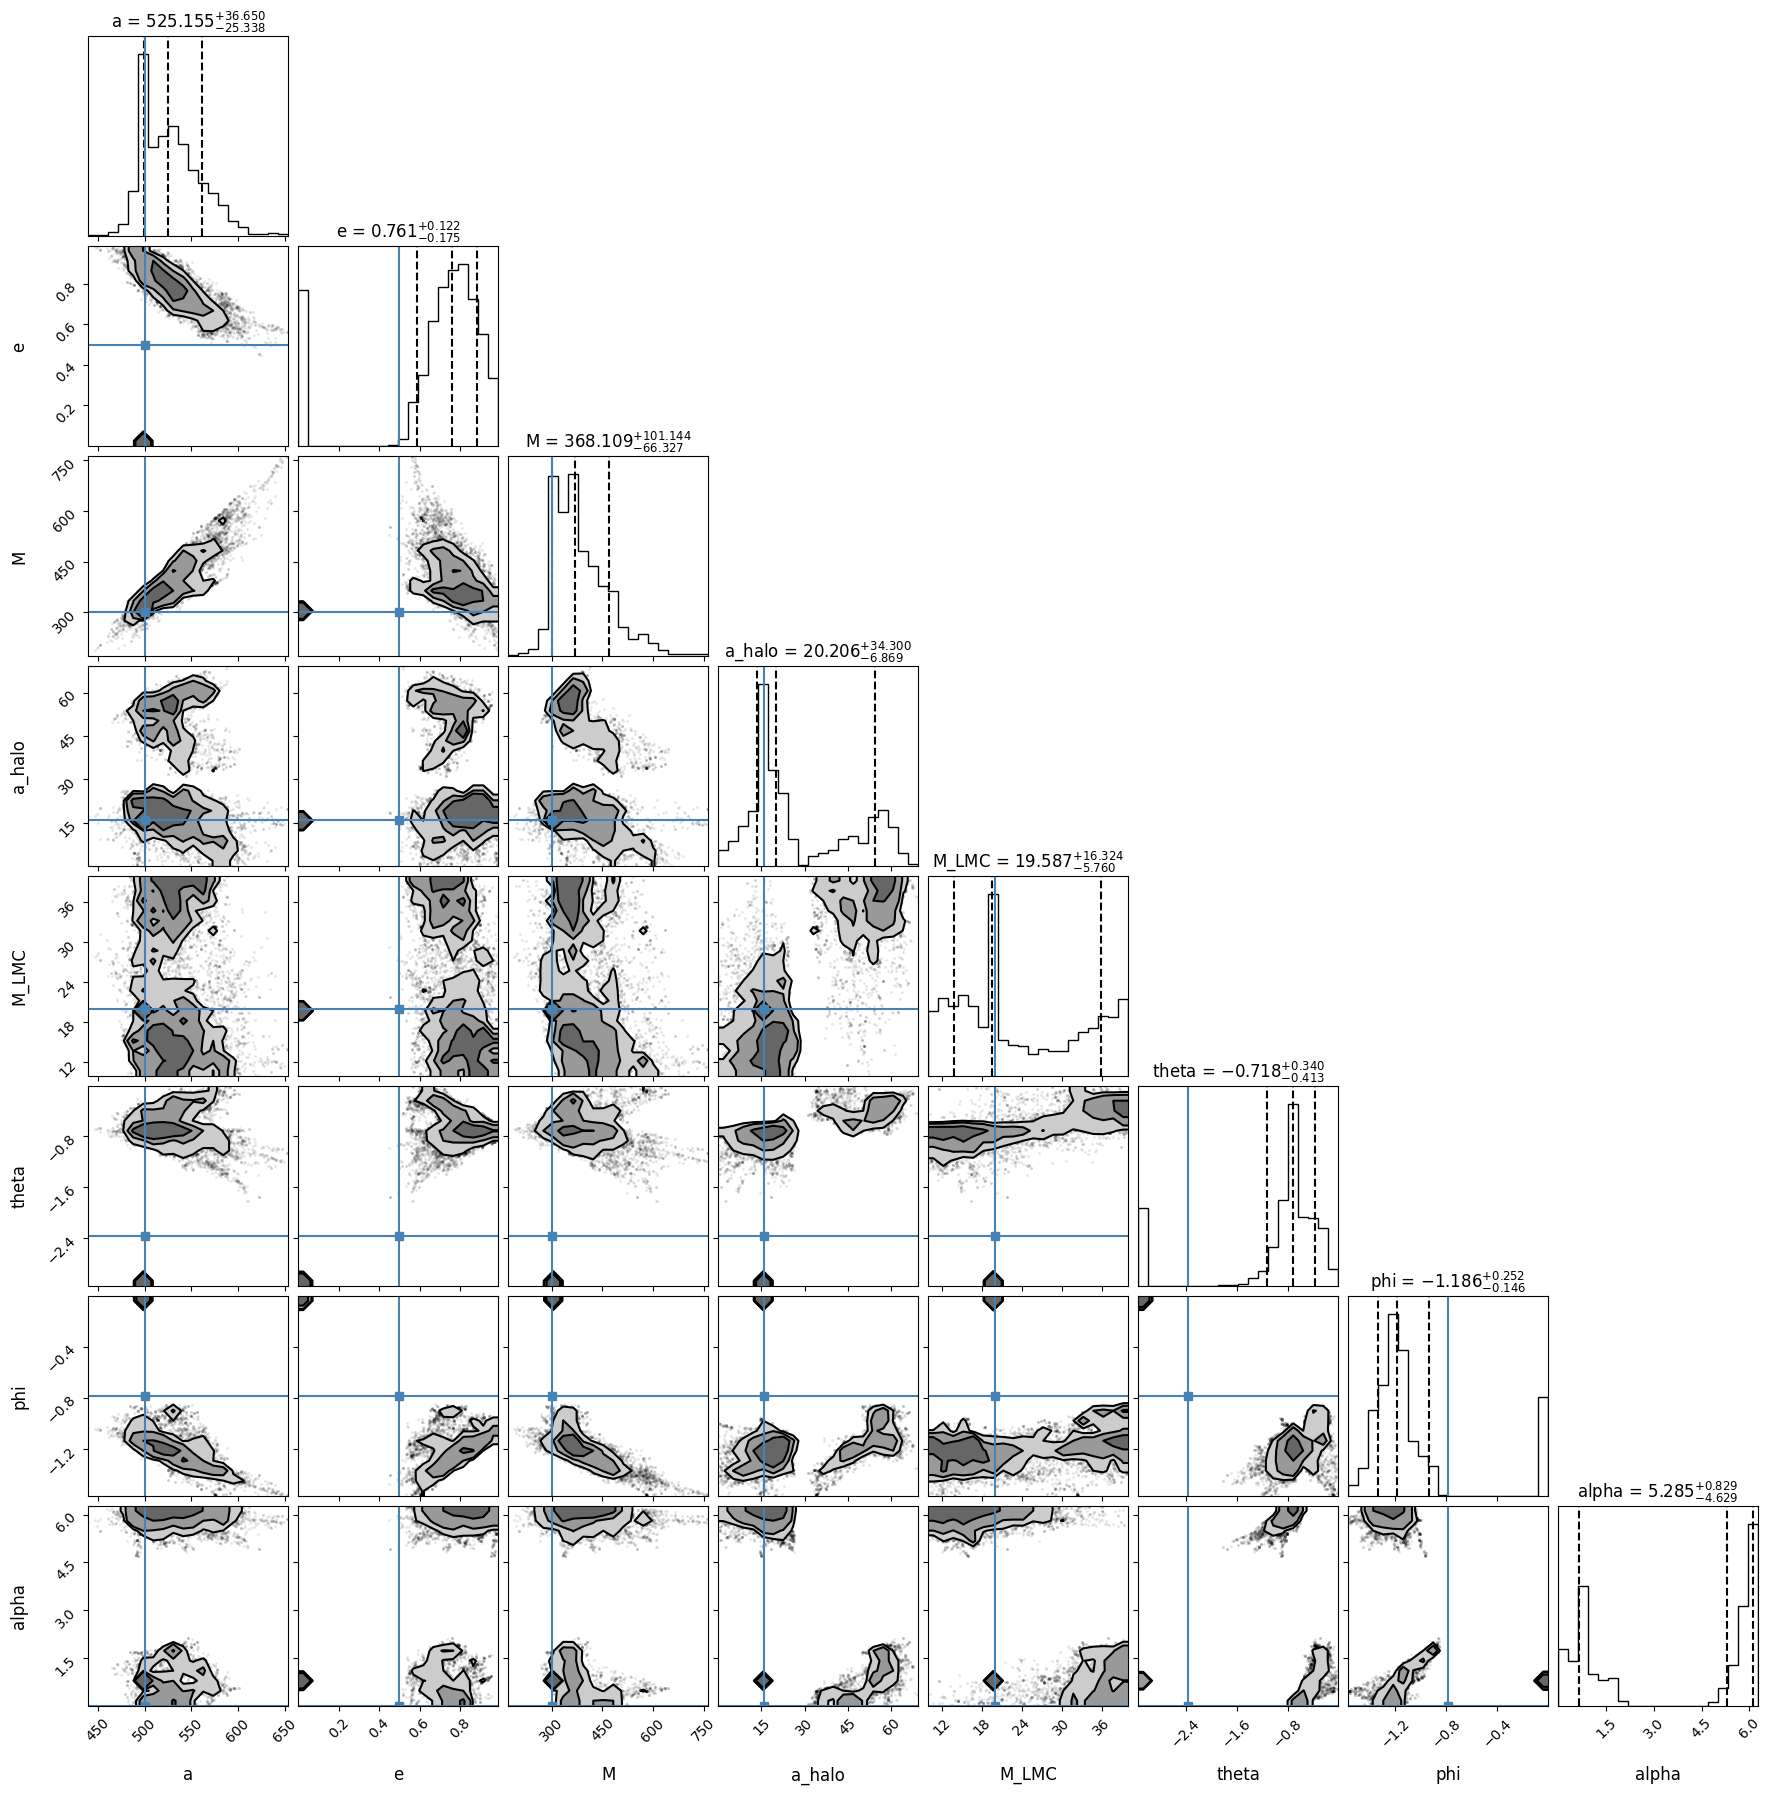

In [168]:
burn_in = int(nsteps * 0.3) 
samples = sampler.get_chain(discard=burn_in, thin=15, flat=True)

fig = corner.corner(samples, labels=["a", "e", "M", "a_halo","M_LMC", "theta", "phi", "alpha"],
                    truths=initial_guess, quantiles=[0.16, 0.5, 0.84], show_titles=True,
                    title_kwargs={"fontsize": 12}, label_kwargs={"fontsize": 12},
                    title_fmt=".3f", fill_contours=True)

plt.show()